# Error Estimation for Water Observations from Space <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers), 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies)

## Description

START WITH WHAT WE KNOW, WHAT IS THE PROBLEM YOU ARE TRYING TO ADDRESS IN THIS NOTEBOOK? WHY DO WE CARE? PROVIDE SOME CONTEXT FOR THE AWESOMENESS. PUMPKIN!

This notebook estimates uncertainties in WOfS for a single waterbody. It replicates [the WOfS classifier](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/classifier.py) with two different approaches for uncertainty estimation:

1. Monte Carlo
2. Estimated marginals of leaf nodes.

A Monte Carlo approach is when you draw random samples from a distribution to estimate some transformation of this distribution. In our case, we will add noise to Landsat images and see how this affects the WOfS predictions. A very uncertain classification will flip between wet and dry with just a little noise, whereas a more certain classification will be unchanged.

The other approach uses the structure of the decision tree to estimate probabilities (see figure below). Each leaf node in the WOfS classifier has a label (wet or dry), but different numbers of training pixels are assigned to each leaf node. We can look at the distribution of truly wet and dry pixels in each leaf node and use this as an estimate for the accuracy in that node. Then, by tracking which leaf node each pixel getting classified ends up in, we can estimate how accurate that pixel classification is.

![WOfS decision tree](../DocumentationFigures/WOfSClassifierTree.JPG "Figure 3 of Mueller et al., 2017, showing the WOfS decision tree")

*Figure 3 of Mueller et al., 2017, showing the WOfS decision tree.*

***

## Getting started

Choose a waterbody in the "Analysis parameters" section and then run all cells.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from datacube.virtual import construct, Transformation, Measurement

sys.path.append("../../../Scripts")
from dea_plotting import rgb
from dea_spatialtools import xr_rasterize
from dea_datahandling import mostcommon_crs
from dea_waterbodies import get_waterbody

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Error-Estimation-WOfS")

### Analysis parameters

Specify the geohash for a waterbody:

In [3]:
# geohash = 'r38psere6'  # Lake Cullivel, NSW
geohash = "r0xf89fch"  # Lake Will, TAS
# geohash = 'r6ktp2tme'  # Rosendahl Reservoir
# geohash = 'r3dp1nxh8'  # Lake Burley Griffin, ACT
# geohash = 'r3f225n9h'  # Weereewa, NSW
# geohash = 'r42yzdv98'  # Lake Hart, SA
# geohash = 'r4m0nb20w'  # Lake Menindee, NSW
# geohash = 'r4hg88vfn'  # Lake Polpitah, NSW

A Landsat surface reflectance product:

In [4]:
product = "ga_ls7e_ard_3"

And a date with observations:

In [5]:
date = "2002-01-29"

### Load the waterbody polygon

We can use `dea_waterbodies.get_waterbody` to get the polygon of any waterbody in DEA Waterbodies.

In [6]:
wb = get_waterbody(geohash)

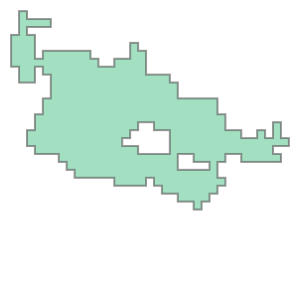

In [7]:
wb.geometry[0]

## Load a test image

We'll load a Landsat image to test out our WOfS probabilities.

Use the waterbody polygon as the location to query:

In [8]:
gpg = datacube.utils.geometry.Geometry(wb.geometry[0], crs=wb.crs)

Retrieve the matching CRS of the Landsat observations:

In [9]:
best_crs = mostcommon_crs(dc, product=product, query=dict(geopolygon=gpg, time=date))

Then load the bands WOfS uses, plus fmask and the terrain shadow mask.

In [10]:
bands = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]

In [11]:
da = dc.load(
    product,
    geopolygon=datacube.utils.geometry.Geometry(wb.geometry[0].buffer(500), crs=wb.crs),
    time=date,
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="cubic",
    measurements=bands + ["fmask", "oa_combined_terrain_shadow"],
)

Save the shadow mask for later use.

In [12]:
shadow_mask = ~np.array(da.isel(time=0).oa_combined_terrain_shadow, dtype=bool)

We can then examine the image.

In [13]:
landsat = da.isel(time=0)

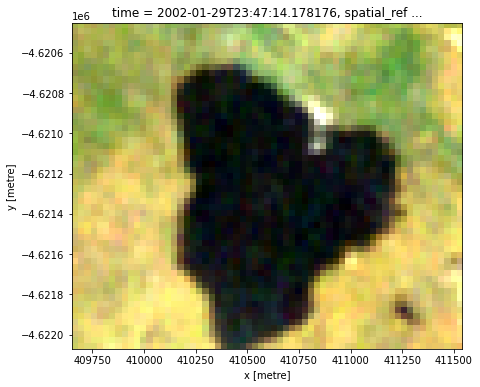

In [14]:
rgb(landsat)

## WOfS implementation

This is a functionally pure reimplementation of WOfS. This lets you do things like accelerate it with libraries that do not permit in-place modification of arrays, e.g. `jax`. This is based on the [actual implementation of WOfS](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/).

In [15]:
def band_ratio(a, b):
    """
    Calculates a normalised ratio index.
    """
    c = (a - b) / np.where(a + b == 0, np.nan, a + b)
    return c

In [16]:
def wofs_classify(px, jnp=np):
    """Classifiy an array of Landsat pixels as wet or dry."""
    ndi_52 = band_ratio(px[4], px[1])
    ndi_43 = band_ratio(px[3], px[2])
    ndi_72 = band_ratio(px[5], px[1])

    b1 = px[0]
    b2 = px[1]
    b3 = px[2]
    b4 = px[3]
    b5 = px[4]
    b7 = px[5]

    # Direct implementation of the WOfS decision tree.
    return jnp.where(
        ndi_52 <= -0.01,
        jnp.where(
            b1 <= 2083.5,
            jnp.where(
                b7 <= 323.5,
                jnp.where(ndi_43 <= 0.61, True, False),
                jnp.where(
                    b1 <= 1400.5,
                    jnp.where(
                        ndi_72 <= -0.23,
                        jnp.where(
                            ndi_43 <= 0.22, True, jnp.where(b1 <= 473.0, True, False)
                        ),
                        jnp.where(b1 <= 379.0, True, False),
                    ),
                    jnp.where(ndi_43 <= -0.01, True, False),
                ),
            ),
            False,
        ),
        jnp.where(
            ndi_52 <= 0.23,
            jnp.where(
                b1 <= 334.5,
                jnp.where(
                    ndi_43 <= 0.54,
                    jnp.where(
                        ndi_52 <= 0.12,
                        True,
                        jnp.where(
                            b3 <= 364.5,
                            jnp.where(b1 <= 129.5, True, False),
                            jnp.where(b1 <= 300.5, True, False),
                        ),
                    ),
                    False,
                ),
                False,
            ),
            jnp.where(
                ndi_52 <= 0.34,
                jnp.where(
                    b1 <= 249.5,
                    jnp.where(
                        ndi_43 <= 0.45,
                        jnp.where(
                            b3 <= 364.5, jnp.where(b1 <= 129.5, True, False), True
                        ),
                        False,
                    ),
                    False,
                ),
                False,
            ),
        ),
    )

In [17]:
def wofs_classify_marginal(px, jnp=np):
    """Get the marginal distribution of wet or dry pixels in WOfS.
    
    The code below applies a direct implementation of the WOfS decision tree,
    except instead of returning the classification,
    we return the percentage of pixels in the training set
    at this leaf node that matched the classification.
    These values are from Mueller+17 Figure 3.
    
    WHY DO WE WANT TO KNOW THIS? WHAT IS THE PURPOSE OF KNOWING THIS? PUMPKIN!
    
    """
    ndi_52 = band_ratio(px[4], px[1])
    ndi_43 = band_ratio(px[3], px[2])
    ndi_72 = band_ratio(px[5], px[1])

    b1 = px[0]
    b2 = px[1]
    b3 = px[2]
    b4 = px[3]
    b5 = px[4]
    b7 = px[5]

    # Direct implementation of the WOfS decision tree,
    # except instead of returning the classification,
    # we return the percentage of pixels in the training set
    # at this leaf node that matched the classification.
    # These values are from Mueller+17 Figure 3.
    return jnp.where(
        ndi_52 <= -0.01,
        jnp.where(
            b1 <= 2083.5,
            jnp.where(
                b7 <= 323.5,
                jnp.where(ndi_43 <= 0.61, 0.972, 1.000),
                jnp.where(
                    b1 <= 1400.5,
                    jnp.where(
                        ndi_72 <= -0.23,
                        jnp.where(
                            ndi_43 <= 0.22, 0.786, jnp.where(b1 <= 473.0, 0.978, 0.967)
                        ),
                        jnp.where(b1 <= 379.0, 0.831, 0.999),
                    ),
                    jnp.where(ndi_43 <= -0.01, 0.977, 0.997),
                ),
            ),
            0.999,
        ),
        jnp.where(
            ndi_52 <= 0.23,
            jnp.where(
                b1 <= 334.5,
                jnp.where(
                    ndi_43 <= 0.54,
                    jnp.where(
                        ndi_52 <= 0.12,
                        0.801,
                        jnp.where(
                            b3 <= 364.5,
                            jnp.where(b1 <= 129.5, 0.632, 0.902),
                            jnp.where(b1 <= 300.5, 0.757, 0.885),
                        ),
                    ),
                    0.974,
                ),
                0.981,
            ),
            jnp.where(
                ndi_52 <= 0.34,
                jnp.where(
                    b1 <= 249.5,
                    jnp.where(
                        ndi_43 <= 0.45,
                        jnp.where(
                            b3 <= 364.5, jnp.where(b1 <= 129.5, 0.616, 0.940), 0.584
                        ),
                        0.979,
                    ),
                    0.984,
                ),
                0.996,
            ),
        ),
    )

We also need a function that converts our Landsat DataArray into the format expected by the classifier.

In [18]:
def xr_to_cube(landsat):
    """Convert an Landsat xarray Dataset to a DataArray for WOfS."""
    return landsat[bands].to_array(dim="band")

In [19]:
landsat_cube = xr_to_cube(landsat)

## Probabilities at leaf nodes

We can call `wofs_classify_marginal` to estimate the probabilities of each pixel based on the leaf node that classified them. This allows us to explore explicitly which parts of the WOfS decision tree resulted in a 'wet' or 'dry' classification. 

WHY DO WE WANT TO DO THIS? WHAT PROBLEM ARE WE TRYING TO SOLVE HERE? 

HOW ARE YOU TESTING THIS? ARE YOU LOOKING FOR PIXELS THAT ARE ONLY MARGINALLY IN ONE NODE, NOT THE OTHER? CAN YOU PLEASE EXPLAIN A BIT MORE ABOUT YOUR THINKING AND HOW YOU'RE TESTING/IMPLEMENTING IT.

PUMPKIN!

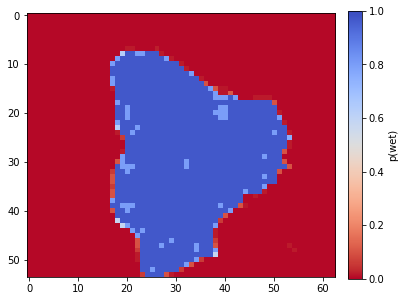

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(
    # Mask shadows.
    np.ma.MaskedArray(
        np.where(
            wofs_classify(landsat_cube.values),
            # Probability that a pixel is wet, rather than the probability that the classification is correct.
            wofs_classify_marginal(landsat_cube.values),
            1 - wofs_classify_marginal(landsat_cube.values),
        ),
        shadow_mask,
    ),
    vmin=0,
    vmax=1,
    cmap="coolwarm_r",
)
plt.colorbar(label="p(wet)", fraction=0.04, pad=0.04)

Very certain pixels will be strongly blue or strongly red in the above plot. Less certain pixels will be less saturated. The edge of the lake is uncertain, as are some pixels in the middle.

## Monte Carlo sampling

Assume every pixel is a multivariate normal with a fixed amount of noise. Sample from this, then calculate WOfS.

SAME AS ABOVE. WHY? HOW? EXPLAIN YOUR TRAIN OF THOUGHT AND HOW YOU'RE TESTING IT. PUMPKIN!

In [21]:
def wofs_monte_carlo(ls_pixels, sigma=50, n_draws=100):
    """Generate Monte Carlo samples from WOfS assuming a given level of Gaussian noise."""
    # ls_pixels is bands x height x width

    # First, draw a noisy sample of the Landsat image:
    # New axes have to go at the start for np.random.normal, but we expect bands to be the first channel, so transpose.
    sample = np.random.normal(
        ls_pixels, sigma, size=(n_draws,) + ls_pixels.shape
    ).transpose(1, 2, 3, 0)
    # Then predict its wetness using WOfS.
    predictions = wofs_classify(sample)
    # Return the mean and standard deviation for each pixel.
    return predictions.mean(axis=-1), predictions.std(axis=-1)

We can then run the Monte Carlo method.

In [22]:
mc = wofs_monte_carlo(landsat_cube, sigma=100)

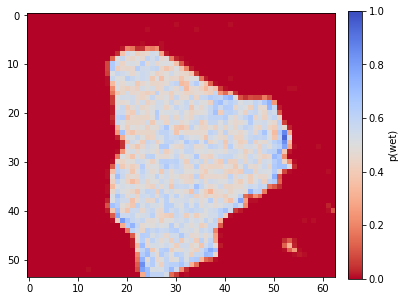

In [23]:
plt.figure(figsize=(6, 6))
plt.imshow(
    np.ma.MaskedArray(mc[0], shadow_mask),
    cmap="coolwarm_r",
    vmin=0,
    vmax=1,
    interpolation="nearest",
)
plt.colorbar(label="p(wet)", fraction=0.04, pad=0.04)

Compared to the leaf nodes approach, Monte Carlo does a much better job at characterising this lake as uncertain. Essentially the whole lake has low certainty, rather than just a few pixels and the edge as in the leaf nodes approach. We also get smoother outputs, whereas the leaf nodes approach has only twice as many possible probabilistic outputs as there are leaf nodes.

WHY DO WE GET THIS OUTPUT? WHAT HAS THIS NOTEBOOK SHOWN US? HOW CAN WE APPLY IT? PUMPKIN!

## Virtual product

Finally let's build a virtual product for loading the marginals. This will allow easy reuse of the method by letting us load it with a datacube-like API.

First we define the transformation:

CAN YOU PLEASE DEFINE 'MARGINALS'. WHY DO WE WANT TO BE ABLE TO EXPLICITLY LOAD THOSE? WHAT PROBLEM ARE YOU SOLVING? PUMPKIN!

In [24]:
# This code is heavily based on the actual WOfS implementation.

# Constants:
WOFS_OUTPUT = [
    {"name": "water", "dtype": "uint8", "nodata": 1, "units": "1"},
    {"name": "probability", "dtype": "float32", "nodata": np.nan, "units": "1"},
]
NO_DATA = (
    1 << 0
)  # (dec 1)   bit 0: 1=pixel masked out due to NO_DATA in NBAR source, 0=valid data in NBAR
MASKED_CLOUD = 1 << 6  # (dec 64)  bit 6: 1=pixel masked out due to cloud
MASKED_CLOUD_SHADOW = 1 << 5  # (dec 32)  bit 5: 1=pixel masked out due to cloud shadow
YES_WATER = 1 << 7

# This function is straight out of WOfS and applies cloud mask.
def fmask_filter(fmask):
    masking = np.zeros(fmask.shape, dtype=np.uint8)
    masking[fmask == 0] += NO_DATA
    masking[fmask == 2] += MASKED_CLOUD
    masking[fmask == 3] += MASKED_CLOUD_SHADOW

    return masking


# This class defines how the virtual product should be calculated from a given Landsat image.
class WOfSClassifier(Transformation):
    def __init__(self):
        # Define our output bands (water and probability).
        self.output_measurements = {m["name"]: Measurement(**m) for m in WOFS_OUTPUT}

    def measurements(self, input_measurements):
        return self.output_measurements

    def compute(self, data):
        # Perform the WOfS transformation for each time step.
        wofs = []
        for time_idx in range(len(data.time)):
            # Get the image at the current time.
            data_time = data.isel(time=time_idx)
            # Convert into the format wofs_classify expects.
            nbar_bands = data_time[bands].to_array(dim="band")
            # Apply the classification function.
            water = xr.DataArray(
                # Multiply by YES_WATER to set the WOfS water bit.
                # Binary or with the cloud mask to set cloud bits.
                (YES_WATER * wofs_classify(nbar_bands).astype(int))
                | fmask_filter(data_time.fmask),
                coords={"x": nbar_bands.coords["x"], "y": nbar_bands.coords["y"]},
                dims=["y", "x"],
            )
            # Apply the probability estimation function.
            # We can ignore cloud masking here: it's already covered by the water measurement.
            probs = xr.DataArray(
                (wofs_classify_marginal(nbar_bands)),
                coords={"x": nbar_bands.coords["x"], "y": nbar_bands.coords["y"]},
                dims=["y", "x"],
            )
            # Construct the dataset that contains water and probability measurements.
            ds = xr.Dataset({"water": water, "probability": probs})
            wofs.append(ds)
        # Concatenate all time steps together along the time axis.
        wofs = xr.concat(wofs, dim="time")
        # And define the units of that time axis.
        wofs.coords["time"] = data.coords["time"]
        # Set the CRS to the input CRS.
        wofs.attrs["crs"] = data.attrs["crs"]
        # Set all values with no data to the no-data value.
        nodata_set = np.bitwise_and(wofs.water.data, NO_DATA) == NO_DATA
        wofs.water.data[nodata_set] = np.array(NO_DATA, dtype="uint8")
        # We now have a product dataset!
        return wofs

Then we build the transformation into a virtual product:

In [25]:
wofs_product = construct(
    transform=WOfSClassifier,
    input=dict(product=product, measurements=bands + ["fmask"]),
)

Now we can `.load` anything we like. Here's the waterbody from before:

In [26]:
wofs_loaded = wofs_product.load(
    dc,
    geopolygon=datacube.utils.geometry.Geometry(wb.geometry[0].buffer(500), crs=wb.crs),
    time=date,
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="nearest",
)

In [27]:
def plot_wofs(wofs_loaded):
    """This function plots a WOfS dataarray."""
    xr.where(
        # Set clouds to nan.
        (wofs_loaded.water != MASKED_CLOUD)
        & (wofs_loaded.water != MASKED_CLOUD_SHADOW),
        # Calculate p(wet) rather than p(WOfS is correct).
        xr.where(
            wofs_loaded.water & 128,
            wofs_loaded.probability,
            1 - wofs_loaded.probability,
        ),
        np.nan,
    ).isel(time=0).plot.imshow(
        vmin=0, vmax=1, cmap="coolwarm_r", interpolation="nearest"
    )

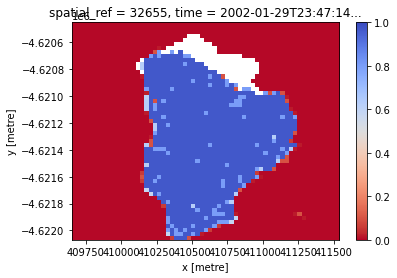

In [28]:
plot_wofs(wofs_loaded)

And here's part of Lake Gordon:

In [29]:
wb_gordon = get_waterbody("r0rvh8fpb")
wofs_gordon = wofs_product.load(
    dc,
    geopolygon=datacube.utils.geometry.Geometry(
        wb_gordon.geometry[0].buffer(500), crs=wb_gordon.crs
    ),
    time="2001-12-28",
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="cubic",
)

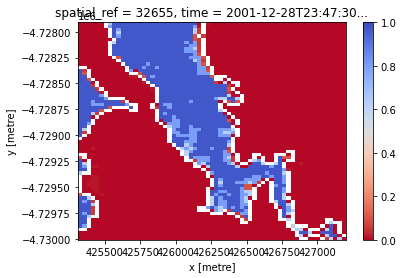

In [30]:
plot_wofs(wofs_gordon)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:** 

In [31]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)